In [1]:
from assets import active
from assets import keys
import re
import time    
import datetime
import GetOldTweets3 as got
import collections
from collections import Counter
import pandas as pd
import string
from string import punctuation 
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import plotly.express as px
import os
from textblob import TextBlob
import nltk
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import urllib
import pickle

class ProfileAnalyzer:
    tweet = None
    fav_tweets = list()
    author=list()

    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret, username):
        self.auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        self.auth.set_access_token(access_token, access_token_secret)
        self.api = tweepy.API(self.auth,wait_on_rate_limit=True)
        self.username = username
    
    def extract(self):
        tweetCriteria = got.manager.TweetCriteria().setUsername(self.username)\
                                           .setSince("2019-01-01")\
                                           .setUntil("2020-06-18")\
                                           .setMaxTweets(100000)
        ProfileAnalyzer.tweet = got.manager.TweetManager.getTweets(tweetCriteria)
        # return ProfileAnalyzer.tweet

    def name_loc(self):
        stat=self.api.get_status(ProfileAnalyzer.tweet[0].id)
        print("The name of the user is: ",stat.user.name)
        print("The location of the user is: ",stat.user.location)

    def sent_anal(self, n):
        data=list()
        tweettext=list()
        if n == 1:
            for i in ProfileAnalyzer.tweet:
                tweettext.append(i.text)
        if n == 2:
            for i in ProfileAnalyzer.fav_tweets:
                tweettext.append(i.text)
        tweetProcessor = PreProcessTweets()
        preprocessedtweets = tweetProcessor.processTweets(tweettext)

        for i in range(len(preprocessedtweets)):
        #  try:
            li=list()
            if n == 1:
                li.append(ProfileAnalyzer.tweet[i].id)
                li.append(ProfileAnalyzer.tweet[i].date)
            if n == 2:
                li.append(ProfileAnalyzer.fav_tweets[i].id)
                li.append(ProfileAnalyzer.fav_tweets[i].created_at)

        #    datetime_object = datetime.strptime(tweet[i].date.strftime('%Y-%m-%d'), '%Y-%m-%d')
        #   li.append(datetime_object)
            blob=TextBlob(preprocessedtweets[i])  
            if blob.sentiment.polarity == 0:
                li.append(0)
            if blob.sentiment.polarity < 0:
                li.append(-1)
            if blob.sentiment.polarity > 0:
                li.append(1)
            data.append(li)
        #     except:
        #         continue
        df = pd.DataFrame(data, columns = ['id','Date', 'Polarity']) 
        self.tseries(df)

    def tseries(self, df):
        result = df.groupby([pd.Grouper(key='Date', freq='8D'), 'Polarity']).count().unstack(fill_value=0).stack().reset_index()
        result = result.rename(columns={"id": "Num of Tweets", "Date":"Time in UTC"})
        time_series = result["Time in UTC"][result['Polarity']==0].reset_index(drop=True)
        fig = px.line(result, x='Time in UTC', y="Num of Tweets", color='Polarity')
        fig.show()

    def noun_list(self, n):
        nounlist=list()
        if n == 1:
            tweets_list = ProfileAnalyzer.tweet
        if n == 2:
            tweets_list = ProfileAnalyzer.fav_tweets
        for i in tweets_list:
            try:
                text1 = active.deEmojify(i.text) 
                text2=active.clean_tweet(text1)
                text3=text2.replace('&amp;', ' ')
                text=word_tokenize(text3)

                hello=nltk.pos_tag(text)
                #print(hello)
                is_noun = lambda pos: pos[:2] == 'NN'
                nouns = [word for (word, pos) in hello if is_noun(pos)] 
                nounlist.extend(nouns)
            except Exception as e:
                continue
                
                
        li1=pd.Series(nounlist)

        active.wordcloud(li1)

    def ner_tagging(self, n):

        os.environ['CLASSPATH'] = keys.classpath

        #Set the Stanford models to the path where the models are stored
        os.environ['STANFORD_MODELS'] = keys.stanford_models

        #Set the java jdk path
        os.environ['JAVAHOME'] = keys.java_path

        #Set the path to the model that you would like to use
        stanford_classifier  =  keys.stanford_classifier

        #Build NER tagger object
        st = StanfordNERTagger(stanford_classifier)

        if n == 1:
            tweets_text = ProfileAnalyzer.tweet
        if n == 2:
            tweets_text = ProfileAnalyzer.fav_tweets

        tweet_text=str()
        
        for i in tweets_text:
            tweet_text=tweet_text+(i.text)
            
        tokenized_text = word_tokenize(tweet_text)
        classified_text = st.tag(tokenized_text)

        li=['ORG','PER','LOC']

        is_noun = lambda pos: pos[:3] in li 
        nouns = [word for (word, pos) in classified_text if is_noun(pos)] 
        #print(nouns)
        noun=pd.Series(nouns)
        active.wordcloud(noun)

    def pull_fav(self):
        auth = list()
        for favorite in tweepy.Cursor(self.api.favorites, id=self.username).items(1000):                    
            auth.append(favorite.user.screen_name)
            # ProfileAnalyzer.author.append(favorite.user.screen_name)        
            ProfileAnalyzer.fav_tweets.append(favorite)
        ProfileAnalyzer.author = pd.Series(auth)

    def pre_cloud(self):
        content = ' '.join(ProfileAnalyzer.author)    
        tokenized_word = word_tokenize(content)
        stop_words=set(stopwords.words("english"))
        filtered_sent=[]
        for w in tokenized_word:
            if w not in stop_words:
                filtered_sent.append(w)
        fdist = FreqDist(filtered_sent)
        fd = pd.DataFrame(fdist.most_common(15), columns = ["Word",     "Frequency"]).drop([0]).reindex()
        return fd

    def wordcloud(self):
        fd = self.pre_cloud()
        y=fd['Frequency']
        x=fd['Word']
    #    print(fd)
        index=np.arange(len(x))
        fig=plt.figure(figsize=(10,10))
        plt.bar(index,y)
        plt.xlabel('Words',fontsize=10)
        plt.ylabel('Frequency',fontsize=10)
        plt.xticks(index,x,fontsize=10,rotation=30)
        plt.show()

    def locations(self):
        fd = self.pre_cloud()
        for i in fd['Word']:
            stat=self.api.get_user(i)
            print(i,":",stat.location)


class PreProcessTweets:
    def __init__(self):
        self._stopwords = set(list(punctuation) + ['AT_USER','URL'])
        
    def processTweets(self, list_of_tweets):
        processedTweets=[]
        for tweet in list_of_tweets:
            processedTweets.append((self._processTweet(tweet)))
        return processedTweets
    
    def _processTweet(self, tweet):
        tweet = tweet.lower() # convert text to lower-case
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
        #tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
        return tweet #[word for word in tweet if word not in self._stopwords]

a = ProfileAnalyzer(keys.consumer_key, keys.consumer_secret, keys.access_token, keys.access_token_secret, '@GTThampi2')
a.extract()
a.pull_fav()

In [86]:
a.name_loc()

The name of the user is:  G T Thampi
The location of the user is:  Bandra Mumbai


In [3]:
################################################################
#Displaying the sentiments of tweets posted by you throughout the year.  
#Polarity 0 = Neutral Sentiment
#Polarity 1 = Positive Sentiment
#Polarity -1 = Negative Sentiment
################################################################
a.sent_anal(1)

'''
This plot does not get displayed on github. Hence I am displaying an image of the same plot.
It will get displayed properly on your local machine when you run it.   
'''

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "assets/pl1.png")


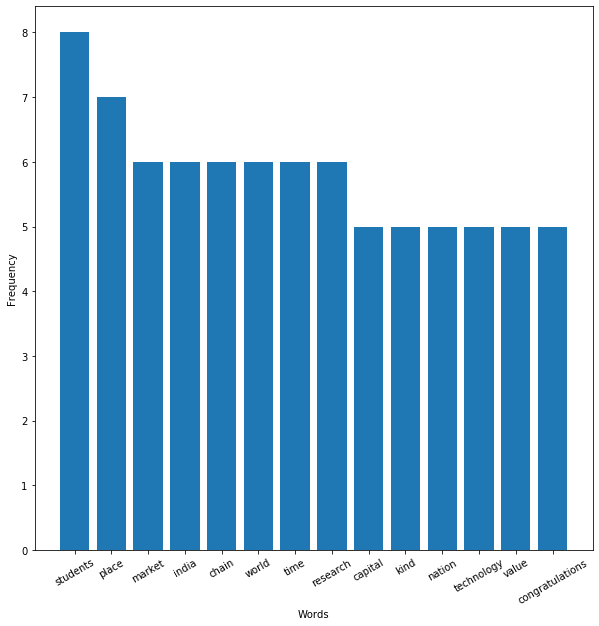

In [88]:
###############################################################################
#Printing the nouns mentioned in the tweets posted by you. 
###############################################################################
a.noun_list(1)

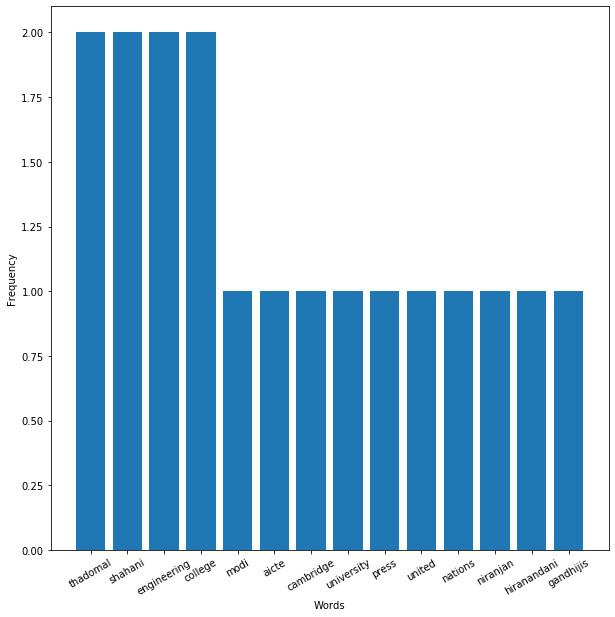

In [89]:
###############################################################################
#Printing the named entities which consist of Organization, Person and Location mentioned in the tweets posted by you. 
###############################################################################
a.ner_tagging(1)


In [2]:

a.sent_anal(2)

'''
This plot does not get displayed on github. Hence I am displaying an image of the same plot.
It will get displayed properly on your local machine when you run it.   
'''

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "assets/pl2.png")


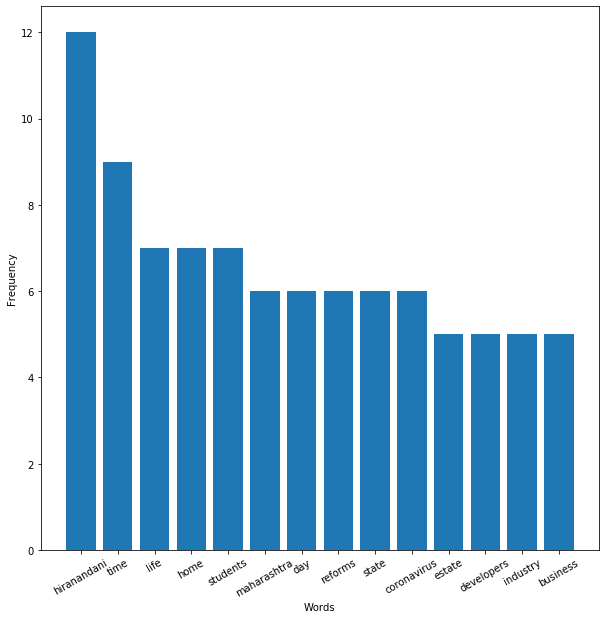

In [91]:
###############################################################################
#Printing the nouns mentioned in the tweets liked by you. 
###############################################################################
a.noun_list(2)

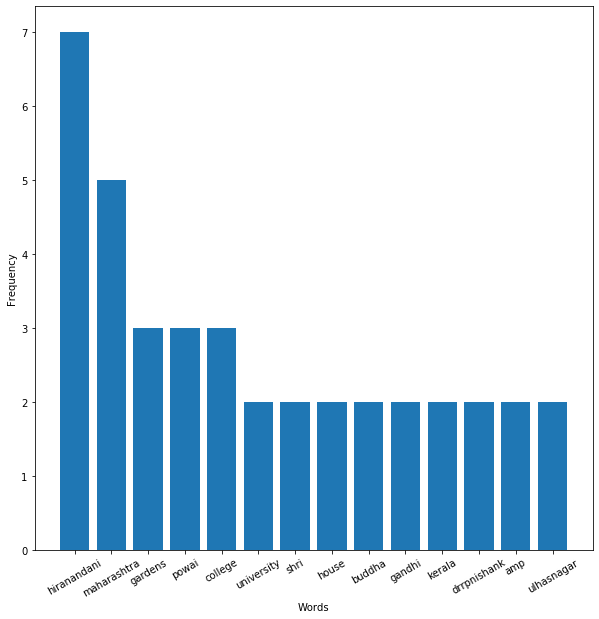

In [92]:
###############################################################################
#Printing the named entities which consist of Organization, Person and Location mentioned in the tweets liked by you. 
###############################################################################
a.ner_tagging(2)

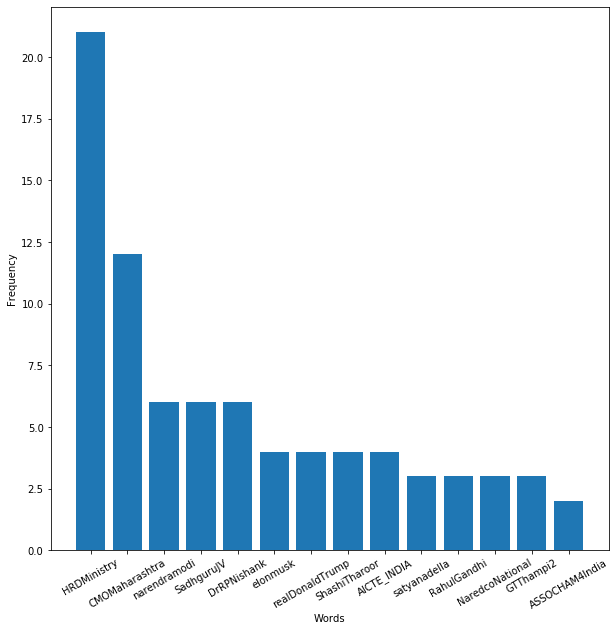

In [93]:
###############################################################################
#Printing top 15 usernames of the users whose tweets were liked most frequently. 
###############################################################################

a.wordcloud()

In [94]:
###############################################################################
#Printing locations of the top 15 users whose tweets were liked most frequently by you. 
###############################################################################

a.locations()

HRDMinistry : Shastri Bhawan, New Delhi
CMOMaharashtra : Mantralaya, Mumbai
narendramodi : India
SadhguruJV : India
DrRPNishank : Haridwar, India
elonmusk : 
realDonaldTrump : Washington, DC
ShashiTharoor : New Delhi & Thiruvananthapuram
AICTE_INDIA : New Delhi, India
satyanadella : 
RahulGandhi : 12, Tughlak Lane, New Delhi
NaredcoNational : New Delhi , India
GTThampi2 : Bandra Mumbai
ASSOCHAM4India : New Delhi, India


In [4]:
followers=set()
following=set()
for user in tweepy.Cursor(api.friends, screen_name="GTThampi2").items():
    following.add(user.screen_name)

for user in tweepy.Cursor(api.followers, screen_name="GTThampi2").items():
    followers.add(user.screen_name)

print(len(followers))
print(len(following))


162
33


In [5]:
print(followers.intersection(following))

{'QuotesSadhguru', 'vnarawade_17'}
